<a href="https://colab.research.google.com/github/hamish-haggerty/AI-hacking/blob/master/BT_MNIST_new3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
!pip install torch==1.11.0 torchvision==0.12.0 torchaudio==0.11.0
!pip install fastai==2.6.3 --no-deps
!pip install self_supervised

!pip install pytest
!pip install ipytest

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [75]:
%%javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,60000)

<IPython.core.display.Javascript object>

In [76]:
import fastai
import self_supervised
import torch
if torch.cuda.is_available():device='cuda'
else:device='cpu'
assert(fastai.__version__ == '2.6.3') #Check that version is 2.6.3

In [77]:
from fastai.vision.all import *
from self_supervised.augmentations import *
from self_supervised.layers import *
from torchvision import transforms
import inspect
import warnings
import random
import math
warnings.filterwarnings("ignore")
import ipytest
ipytest.autoconfig()
import pytest

In [78]:
#Like most other SSL algorithms BT's model consists of an encoder and projector (MLP) layer.
#Definition is straightforward:
#https://colab.research.google.com/github/KeremTurgutlu/self_supervised/blob/master/nbs/14%20-%20barlow_twins.ipynb#scrollTo=1M6QcUChcvpz
class BarlowTwinsModel(Module):
    """An encoder followed by a projector
    """
    def __init__(self,encoder,projector):self.encoder,self.projector = encoder,projector
        
    def forward(self,x): return self.projector(self.encoder(x))

In [79]:
#HOWEVER instead of directly using the above, by passing both an encoder and a projector, create_barlow_twins_model
#function can be used by minimally passing a predefined encoder and the expected input channels.

#In the paper it's mentioned that MLP layer consists of 3 layers... following function will create a 3 layer
#MLP projector with batchnorm and ReLU by default. Alternatively, you can change bn and nlayers. 

#Questions: Why torch.no_grad() when doing this?
def create_barlow_twins_model(encoder, hidden_size=256, projection_size=128, bn=True, nlayers=3):
    "Create Barlow Twins model"
    n_in  = in_channels(encoder)
    with torch.no_grad(): representation = encoder(torch.randn((2,n_in,128,128)))
    projector = create_mlp_module(representation.size(1), hidden_size, projection_size, bn=bn, nlayers=nlayers) 
    apply_init(projector)
    return BarlowTwinsModel(encoder, projector)

#Similar to above. Simple API to make the BT model:

In [80]:
#BarlowTwins Callback
#The following parameters can be passed:
# - aug_pipelines
# Imb lambda is the weight for redundancy reduction term in the loss function

@delegates(get_multi_aug_pipelines)
def get_barlow_twins_aug_pipelines(size,**kwargs): return get_multi_aug_pipelines(n=2,size=size,**kwargs)

In [ ]:
#Uniform random number between a and b
def Unif(a,b):
    return (b-a)*torch.rand(1).item()+a

In [81]:
def random_sinusoid(x,std=0.1,seed=0):
    
    seed_everything(seed=seed)    
    t=(std) * torch.randn(1,500).to(device)
    s=(std) * torch.randn(1,500).to(device)
    
    u=torch.randn(1,500).to(device)
    v=torch.randn(1,500).to(device)

    a=(0.2) * torch.randn(1,500).to(device)
    b=(0.2) * torch.randn(1,500).to(device)
    # N = torch.abs(a) + torch.abs(b)
    # a = a/N
    # b = b/N

    return a*torch.sin(t*x[:,]*math.pi+u) + b*torch.cos(s*x[:,]*math.pi+v)


    
    #return torch.sin(t*math.pi*x+u) + torch.cos(s*math.pi*x + v)

In [82]:
#New stuff
class Cdiff_Rand:
    
    def __init__(self,seed,bs,std=0.1,K=2):
        self.seed=seed
        self.std=std
        self.K=2
        self.bs=bs

    def __call__(self,z1norm,z2norm):
        
        cdiff_rand=0
        for i in range(self.K):

            z1norm_2,z2norm_2 = random_sinusoid(z1norm,std=self.std,seed=self.seed+i), random_sinusoid(z2norm,std=self.std,seed=2*self.seed+i)
            cdiff_rand = C_z1z2(z1norm=z1norm,z1norm_2=z1norm_2,z2norm=z2norm,z2norm_2=z2norm_2,bs=bs)

        cdiff_rand=(1/self.K)*cdiff_rand
    
        return cdiff_rand
  

In [83]:
#New stuff
def C_z1z2(z1norm,z1norm_2,z2norm,z2norm_2,bs):
    
    Ctem1 =  (z1norm.T @ z2norm_2) / bs
    Ctem2 = (z1norm_2.T @ z2norm) / bs
    cdiff_2 = (0.5*Ctem1.pow(2) + 0.5*Ctem2.pow(2))

    return cdiff_2

class Max_Corr(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(ps,ps)
        self.fc2 = nn.Linear(ps,ps)

        self.fc3 = nn.Linear(ps,ps)
        self.fc4 = nn.Linear(ps,ps)

        self.sigmoid = nn.Sigmoid()

        self.relu = nn.ReLU()
    def forward(self,x,y):

        x=self.sigmoid(self.fc1(x)) #when (sigmoid,relu) GREAT results, with (sigmoid,sigmoid) TERRIBLE. Currently testing (relu,relu)
        x=self.fc2(x)
       
        y=self.relu(self.fc3(y)) #originally had relu and got really good results. If we can't reproduce those results, possible reasons:
                                    #results were due to chance; or having relu on one branch (and sigmoid on the other) helps via breaking
                                      #the symmetry! Other idea: set fc1=fc3, fc2=fc4. 
        y=self.fc4(y)

        return x,y

class Cdiff_Sup:
    
    def __init__(self,I,inner_steps,bs):
        
        self.I=I
        self.inner_steps=inner_steps
        self.bs=bs
        self.max_corr = Max_Corr()
        if device == 'cuda':
            self.max_corr.cuda()
        
    def inner_step(self,z1norm,z2norm):
    
        max_corr=self.max_corr
        I=self.I
        bs=self.bs
        inner_steps=self.inner_steps

        z1norm=z1norm.detach()
        z2norm=z2norm.detach()

        # z1norm=z1norm[:,0]
        # z2norm=z2norm[:,0]

        max_corr = Max_Corr()
        max_corr.cuda()
    
        # for p in max_corr.parameters():
        #     p.requires_grad=True]

        optimizer = torch.optim.Adam(list(max_corr.parameters()),lr=0.001)
        for i in range(inner_steps):
            z1norm_2,z2norm_2=max_corr(z1norm,z2norm)
            #z1norm_2 = (z1norm_2 - z1norm_2.mean(0)) / z1norm_2.std(0, unbiased=False)
        
            assert (z1norm_2.shape,z2norm_2.shape) == (z1norm.shape,z2norm.shape)

            # Ctem1 =  (z1norm.T @ z2norm_2) / bs
            # Ctem2 = (z1norm_2.T @ z2norm) / bs
            # cdiff_2 = (0.5*Ctem1.pow(2) + 0.5*Ctem2.pow(2))

            cdiff_2 = C_z1z2(z1norm=z1norm,z1norm_2=z1norm_2,z2norm=z2norm,z2norm_2=z2norm_2,bs=bs)
            #cdiff_2=Ctem.pow(2)

            inner_loss=-1*(cdiff_2*(1-I)).mean()

            optimizer.zero_grad()
            inner_loss.backward()
            optimizer.step()
        
        for p in max_corr.parameters():
            p.requires_grad=False
            
        return max_corr
    
    def __call__(self,z1norm,z2norm):
        
            max_corr =  self.inner_step(z1norm,z2norm)
            z1norm_2,z2norm_2 = max_corr(z1norm,z2norm)
      
            cdiff_sup = C_z1z2(z1norm=z1norm,z1norm_2=z1norm_2,z2norm=z2norm,z2norm_2=z2norm_2,bs=bs)
    
            return cdiff_sup


In [99]:
#export
class BarlowTwins(Callback):
    order,run_valid = 9,True
    def __init__(self, aug_pipelines, lmb=5e-3, print_augs=False):
        assert_aug_pipelines(aug_pipelines)
        self.aug1, self.aug2 = aug_pipelines
        if print_augs: print(self.aug1), print(self.aug2)
        store_attr('lmb')
        self.index=-1

        self.inner_steps=4
        
    def before_fit(self): 
        self.learn.loss_func = self.lf
        nf = self.learn.model.projector[-1].out_features
        self.I = torch.eye(nf).to(self.dls.device)

    def update_seed(self):
        
        indexmod=2
        if self.index%indexmod == 0: #every `indexmod` index update the seed (best we have found so far)
            self.seed = np.random.randint(0,10000)

    def before_epoch(self):
        self.index=-1

        if self.epoch%10==0:
            self.inner_steps += 1
            
    def before_batch(self):
        xi,xj = self.aug1(self.x), self.aug2(self.x)
        self.learn.xb = (torch.cat([xi, xj]),)

        self.index=self.index+1

        self.update_seed()

        
        #Uncomment to run standard BT
    def lf(self, pred, *yb): #pred is (bs+bs)*projection_size
        bs,nf = pred.size(0)//2,pred.size(1)

        z1, z2 = pred[:bs],pred[bs:] #so z1 is bs*projection_size, likewise for z2

        z1norm = (z1 - z1.mean(0)) / z1.std(0, unbiased=False)
        z2norm = (z2 - z2.mean(0)) / z2.std(0, unbiased=False)
        
        C = (z1norm.T @ z2norm) / bs 
        cdiff = (C - self.I)**2
        loss = (cdiff*self.I + cdiff*(1-self.I)*self.lmb).sum() 
        return loss


    # def lf(self, pred, *yb): #pred is (bs+bs)*projection_size
    #     bs,nf = pred.size(0)//2,pred.size(1)

    #     #All standard, from BT
    #     z1, z2 = pred[:bs],pred[bs:] #so z1 is bs*projection_size, likewise for z2
    #     z1norm = (z1 - z1.mean(0)) / z1.std(0, unbiased=False)
    #     z2norm = (z2 - z2.mean(0)) / z2.std(0, unbiased=False)
        
    #     C = (z1norm.T @ z2norm) / bs 
    #     cdiff = (C - self.I)**2



    #     # #Let's change this block to rewritten (should do same thing)
    #     # max_corr = inner_step(z1norm,z2norm,I=self.I,inner_steps=5)#,inner_steps=self.inner_steps)
    #     # z1norm_2,z2norm_2 = max_corr(z1norm,z2norm)
    #     # Ctem1 =  (z1norm.T @ z2norm_2) / bs
    #     # Ctem2 = (z1norm_2.T @ z2norm) / bs
    #     # #Ctem = (z1norm_2.T @ z2norm_2) / bs
    #     # #cdiff_2 = Ctem.pow(2)
    #     # cdiff_2 = (0.5*Ctem1.pow(2) + 0.5*Ctem2.pow(2)) #+ 0.1*Ctem.pow(2)


    #     CdiffSup = Cdiff_Sup(I=self.I,inner_steps=5,bs=bs)
    #     cdiff_2 = CdiffSup(z1norm,z2norm)

    #     CdiffRand = Cdiff_Rand(seed=self.seed,bs=bs,std=0.2,K=2)
    #     cdiff_2_2 = CdiffRand(z1norm,z2norm)

    #     # #Let's change this block to rewritten (should do same thing)
    #     # K=2
    #     # cdiff_2_2=0
    #     # for i in range(K):
    #     #     #p=Exp_sample(loc=1.5,scale=2.0)
    #     #     #p=Unif(0.9,2.5)
    #     #     #z1norm_2 = p_norm(z1norm,p=p)

    #     #     #p=Exp_sample(loc=1.5,scale=2.0)
    #     #     #p=Unif(0.9,2.5)
    #     #     #z2norm_2 = p_norm(z2norm,p=p)

    #     #     z1norm_2 = random_sinusoid(z1norm,std=0.1,seed=self.seed+i)
    #     #     z2norm_2 = random_sinusoid(z2norm,std=0.1,seed=2*self.seed+i)

    #     #     #C = (z1norm_2.T @ z2norm_2) / bs
    #     #     C_1 = (z1norm.T @ z2norm_2) / bs
    #     #     C_2 = (z1norm_2.T @ z2norm) / bs

    #     #     #cdiff_2 = 0.5*(C_1).pow(2) + 0.5*(C_2).pow(2)
    #     #     #cdiff_2_2 = cdiff_2_2 + cdiff_2
    #     #     cdiff_2_2 = cdiff_2_2 + 0.5*C_1.pow(2)+0.5*C_2.pow(2)
        
    #     # cdiff_2_2=(1/K)*cdiff_2_2


    #     cdiff_2 = 0.5*cdiff_2_2 + 0.5*cdiff_2
            
            
    #     l2 = cdiff_2*(1-self.I)*self.lmb #Is either the standard term - or not.


    #     loss = (cdiff*self.I + l2).sum()
    #     torch.cuda.empty_cache()
    #     return loss


    @torch.no_grad()
    def show(self, n=1):
        bs = self.learn.x.size(0)//2
        x1,x2  = self.learn.x[:bs], self.learn.x[bs:] 
        idxs = np.random.choice(range(bs),n,False)
        x1 = self.aug1.decode(x1[idxs].to('cpu').clone()).clamp(0,1)
        x2 = self.aug2.decode(x2[idxs].to('cpu').clone()).clamp(0,1)
        images = []
        for i in range(n): images += [x1[i],x2[i]] 
        return show_batch(x1[0], None, images, max_n=len(images), nrows=n)

In [100]:
#Debugging cell - delete later (similar to cell below)
ps=500
hs=500
fastai_encoder = create_encoder('xresnet18', n_in=1, pretrained=False)
model = create_barlow_twins_model(fastai_encoder, hidden_size=hs,projection_size=ps)# projection_size=1024)
#So aside from size, randomresizedcrop takes in two args: resize_scale and resize_ratio. So we want to put in 
#values for these which is tantamount to doing nothing
#So if we choose resize_scale=(1,1) then the images look the same.
#IMPORTANT: So this aug pipelines, insofar as I can tell at the moment, is tantamount to "do nothing"
aug_pipelines = get_barlow_twins_aug_pipelines(size=28, rotate=True,flip_p=0,resize_scale=(0.7,1), jitter=False, bw=False,blur=True,blur_p=0.5,blur_s=8, stats=None, cuda=True)
#learn = Learner(dls, model,ShortEpochCallback(0.001), cbs=[BarlowTwRMSProp(model.parameters(),lr=0.1, mom=0.9)ins(aug_pipelines, print_augs=True)])
opt = torch.optim.RMSprop
#partial(OptimWrapper, opt=opt)
learn = Learner(dls,model, cbs=[BarlowTwins(aug_pipelines, print_augs=True)])
#learn = Learner(dls, model,opt_func=opt_func, cbs=[BarlowTwins(aug_pipelines, print_augs=True)])

learn.fit(100) #300                            

Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> RandomGaussianBlur -- {'p': 0.5, 's': 8, 'same_on_batch': False} -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}
Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> RandomGaussianBlur -- {'p': 0.5, 's': 8, 'same_on_batch': False} -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}


epoch,train_loss,valid_loss,time
0,151.405121,None,00:20
1,106.585541,None,00:19
2,83.405525,None,00:19


KeyboardInterrupt: ignored

In [86]:
#new
def seed_everything(seed=42):
    """"
    Seed everything.
    """   
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

def tune_set(items0,seed=None,bs_tune=20):
    
    seed_everything(seed=seed)
    
    items0=items0.shuffle()
    d = {'0':0,'1':0,'2':0,'3':0,'4':0,'5':0,'6':0,'7':0,'8':0,'9':0}
    ITEMS=[]
    for i in items0:
        s=str(i).split('/training/')[1][0]
        if d[s] is 0 or d[s] is 1:
            ITEMS.append(i)
            d[s]+=1
    #items0=ITEMS

    for i in items0:
        if i not in ITEMS:
            ITEMS.append(i)
            
    split = IndexSplitter(list(range(bs_tune)))

    tds_tune = Datasets(ITEMS, [PILImageBW.create, [parent_label, Categorize()]], splits=split(ITEMS)) #Or do we want this?
    dls_tune = tds_tune.dataloaders(bs=bs_tune,num_workers=0, after_item=[ToTensor(), IntToFloatTensor()], device=device)
    
    return dls_tune


In [87]:
def shuffle_items(items,seed):
    """Helper function to sort a list according to given random seed
    """
    items.sort()
    
    if seed !=None:
        seed_everything(seed=seed)
        items=items.shuffle()
    
    return items

class BT_Data:
    
    def __init__(self,items,seed=42,ts=16384,bs=512,tune_s=2000,bs_tune=20,bs_test=578):
        
        self.ts=ts
        self.bs=bs
        self.tune_s=tune_s
        self.bs_tune=bs_tune
        self.bs_test=bs_test
        
        self._seed=seed
        self.seed=seed
        items=shuffle_items(items,seed)
        self.items=items

    @property
    def seed(self):
        return self._seed
    
    @seed.setter #When we update the seed, we update the datasets (so items and dls objects) accordingly
    def seed(self,val):
        self._seed=val
        self.items = shuffle_items(items,val)
        self.build_items_i()
        self.build_dls()
        
    def build_items_i(self):
        self.items1 = self.items[0:ts] #train BT on these guys
        self.items0 = self.items[self.ts:self.ts+self.tune_s] #for fine tuning - just choose 2000 guys to extract 20 for fine tuning 
        self.items2 = self.items[self.ts+self.tune_s:] #test on remainder
        
    def build_dls(self):
        
        split = RandomSplitter(valid_pct=0.0)
        tds = Datasets(self.items1, [PILImageBW.create, [parent_label, Categorize()]], splits=split(self.items1))
        self.dls = tds.dataloaders(bs=self.bs,num_workers=0, after_item=[ToTensor(), IntToFloatTensor()], device=device)

        #Evaluate linear classifier on this guy
        split = RandomSplitter(valid_pct=0.0) #randomly split training set into training and validation
        tds_test = Datasets(self.items2, [PILImageBW.create, [parent_label, Categorize()]], splits=split(self.items2)) #Or do we want this?
        self.dls_test = tds_test.dataloaders(bs=self.bs_test,num_workers=0, after_item=[ToTensor(), IntToFloatTensor()], device=device)



In [88]:
def build_BT_Data(items,seed,tune_seed):
    ts=16384
    bs=512
    tune_s=2000
    bs_tune=20
    bs_test=578
    
    k=dict(seed=seed,ts=ts,bs=bs,tune_s=tune_s,bs_tune=bs_tune,bs_test=bs_test)
    bt_dataset = BT_Data(items=items,**k)

    items = bt_dataset.items
    items1 = bt_dataset.items1
    items0 = bt_dataset.items0
    items2 = bt_dataset.items2

    dls = bt_dataset.dls
    dls_test = bt_dataset.dls_test

    dls_tune=tune_set(items0=items0,seed=seed,bs_tune=bs_tune)
    
    return dict(seed=seed,tune_seed=tune_seed,items=items,items1=items1,items0=items0,items2=items2,dls=dls,dls_test=dls_test,dls_tune=dls_tune)


In [98]:
#new

path = untar_data(URLs.MNIST)
items = get_image_files(path/'training') #i.e. NOT testing!!!
items.sort()

seed=42
tune_seed=10
ts=16384
bs=512
tune_s=2000
bs_tune=20
bs_test=578

bt_data = BT_Data(items=items,seed=seed,ts=ts,bs=bs,tune_s=tune_s,bs_tune=bs_tune,bs_test=bs_test)

items1=bt_data.items1
items0=bt_data.items0
items2=bt_data.items2

dls=bt_data.dls
dls_test=bt_data.dls_test



In [90]:
%%ipytest -qq
#TODO: Rewrite so works for both (seed,tune_seed) = (42,10) and (420,100). At the moment 

labeller = using_attr(RegexLabeller(pat = r'(\d+).png$'), 'name')
convert_tensor = transforms.ToTensor()
Expected_first_item = {42:{'items1':'19825','items0':'40684','items2':'43064'},420:{'items1':'44942','items0':'23821','items2':'908'}}
Expected_first_dls = {42:{'dls':0.085169,'dls_test':0.099924},420:{'dls':0.183678,'dls_test':0.162825}}
Expected_first_dls_tune = {(42,55):0.093707,(420,55):0.1513355}

bt_data_42 = build_BT_Data(items=items,seed=42,tune_seed=10)
bt_data_420 = build_BT_Data(items=items,seed=420,tune_seed=100)

def verify_DatasetShape(dls_obj,batch_size,ds_settype='train'):
    """"Helper function to verify shape of a dls object given the batch size; ds_settype is either `train` or 
        `valid`. The idea is we want the batch_size to divide the length of the dlsobj.
    """
    
    tem = len(getattr(dls_obj,ds_settype)) #length of dlsobj.train or dlsobj.valid depending on settpe
    return tem*batch_size == len(getattr(dls_obj,ds_settype+'_ds'))

def verify_first_item(items,expected):
    """Helper function to verify first element of items is as expected, given random seed of 42
    """
        
    return labeller(items[0]) == expected
        
def verify_first_dls(dls_obj,expected,ds_settype='train'):
    """Helper function to verify first element of the given dls object is as expected, given random seed of 42.
        Note that ds_settype is either `train` or `valid
    """
    
    #All we are doing here is getting the first tensor in, for example e.g. dls_obj.train_ds and computing
    #the mean of all the elements. If random seed is same, then it should give the same results
    z=convert_tensor(next(iter(getattr(dls_obj,ds_settype+'_ds')))[0]).mean().item()
    
    #logging.debug(f'with {ds_settype} has: {z}')
    assert z-expected < 0.0001

    
@pytest.mark.parametrize('bt_dataset',[bt_data_42,bt_data_420])
class Test_shapes:
    
    def test_shape_dlsobjects(self,bt_dataset):
        """"Test the shape of each dlsobj
        """
    
        assert verify_DatasetShape(bt_dataset['dls'],batch_size=bs,ds_settype='train')

        assert verify_DatasetShape(bt_dataset['dls_tune'],batch_size=bs_tune,ds_settype='valid')

        assert verify_DatasetShape(bt_dataset['dls_test'],batch_size=bs_test,ds_settype='train')
    
    def test_length_dlsobjects(self,bt_dataset):
        """"Test the length of each dlsobj that we use
        """
        assert len(bt_dataset['dls'].train_ds) == ts and len(bt_dataset['dls_tune'].valid_ds) == bs_tune and len(bt_dataset['dls_test'].train_ds)==41616
    
    
@pytest.mark.parametrize('bt_dataset',[bt_data_42,bt_data_420])   
class Test_first:
    
    def test_first_item(self,bt_dataset):
        """"Verify that the first item of each items is as expected
        """

        seed = bt_dataset['seed']

        assert verify_first_item(bt_dataset['items1'],Expected_first_item[seed]['items1'])

        assert verify_first_item(bt_dataset['items0'],Expected_first_item[seed]['items0'])

        assert verify_first_item(bt_dataset['items2'],Expected_first_item[seed]['items2'])

    def test_first_dlsobj(self,bt_dataset):
        """Verify that the first item of each dlsobj is as expected
        """
        seed = bt_dataset['seed']
        dls = bt_dataset['dls']
        dls_test = bt_dataset['dls_test']
        items0 = bt_dataset['items0']

        verify_first_dls(dls,ds_settype='train',expected=Expected_first_dls[seed]['dls'])
        verify_first_dls(dls_test,ds_settype='train',expected=Expected_first_dls[seed]['dls_test'])

        tune_seed=55
        dls_tune=tune_set(items0,seed=tune_seed,bs_tune=bs_tune)

        verify_first_dls(dls_tune,ds_settype='valid',expected=Expected_first_dls_tune[(seed,tune_seed)])


@pytest.mark.parametrize('bt_dataset',[bt_data_42,bt_data_420])
def test1_tune_set(bt_dataset):
    """Check whether the function `tune_set` gives us the expected values"""
    

    seed=bt_dataset['seed']
    tune_seed=bt_dataset['tune_seed']
    items0 = bt_dataset['items0']
    
    if tune_seed==10 and seed==42:
        expected = {10:0.12255,11:0.153564,12:0.12781,13:0.129523,14:0.13019}
    
    elif tune_seed==100 and seed==420:
        expected={100:0.136104,101:0.120989,102:0.1381390,103:0.1380412,104:0.14285138}
        
    for i in range(5):
        #seed_everything(seed=seed)
        dls_tune=tune_set(items0,seed=tune_seed+i,bs_tune=20)
        x_mean=0
        for x,y in dls_tune.valid:
            x_mean += x.mean()

        assert abs(x_mean-expected[tune_seed+i])<0.0001


..........                                                                                   [100%]


Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> RandomGaussianBlur -- {'p': 0.5, 's': 8, 'same_on_batch': False} -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}
Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> RandomGaussianBlur -- {'p': 0.5, 's': 8, 'same_on_batch': False} -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}


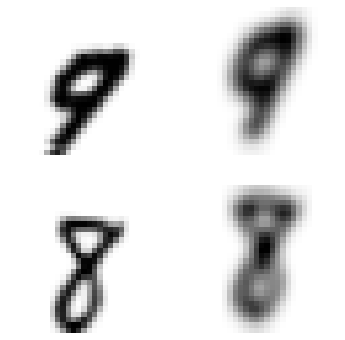

In [37]:
#A "reasonable" composite augmentation: initially copy pasted BT. We run this cell a few times to check it makes sense
#Also define encoder and model
fastai_encoder = create_encoder('xresnet18', n_in=1, pretrained=False)
model = create_barlow_twins_model(fastai_encoder, hidden_size=10,projection_size=10)# projection_size=1024)
#So aside from size, randomresizedcrop takes in two args: resize_scale and resize_ratio. So we want to put in 
#values for these which is tantamount to doing nothing
#So if we choose resize_scale=(1,1) then the images look the same.
#IMPORTANT: So this aug pipelines, insofar as I can tell at the moment, is tantamount to "do nothing"
aug_pipelines = get_barlow_twins_aug_pipelines(size=28, rotate=True,flip_p=0,resize_scale=(0.7,1), jitter=False, bw=False,blur=True,blur_p=0.5,blur_s=8, stats=None, cuda=False)
#learn = Learner(dls, model,ShortEpochCallback(0.001), cbs=[BarlowTwins(aug_pipelines, print_augs=True)])
learn = Learner(dls, model, cbs=[BarlowTwins(aug_pipelines, print_augs=True)])

#dls.valid.bs = len(dls.valid_ds) #Set the validation dataloader batch size to be the length of the validation dataset

b = dls.one_batch()
learn._split(b)
learn('before_batch')
axes = learn.barlow_twins.show(n=2)

In [72]:
#Simple linear classifier
class LinearClassifier(nn.Module):
    
    def __init__(self,zdim):
            
        super().__init__()
        self.fc1 = nn.Linear(zdim,10) #As 10 classes for mnist
        
    def forward(self,x):
        x = cast(self.fc1(x),Tensor) #so we have to use cross entropy loss. cast is because using old version fastai 
        return x

def turnoffgrad_model(fastai_encoder):
    for p in fastai_encoder.parameters():
        p.requires_grad=False
        
    return fastai_encoder

#NB: Will give same random 20-tune set (for fixed random seed), only if the cell
#"#Get the dataloader and set batch size" is the same. Perhaps later we can make this cell a function of that one. 
#Functions to train and evaluate head
fastai_encoder.eval()
encoder_nograd = turnoffgrad_model(fastai_encoder) 
def train_head(encoder_nograd,tune_seed=10,bs_tune=20): #The seed choses a different (20) samples for training the head. 2 of each class
    """Train head on a tune_set, chosen through given tune_seed for reproducibility if needed
    """
                                    # of the tune_seed)
    
    dls_tune=tune_set(items0,seed=tune_seed,bs_tune=bs_tune) #different random tune set each time (but as a function of tune_seed)
 
    N=len(dls_tune.valid)*bs_tune 
    assert N == len(dls_tune.valid_ds) #Check that the tune set (valid) is divided by the batch size
    assert len(dls_tune.valid_ds) == bs_tune

    zdim=1024 #see above
    head = LinearClassifier(zdim=zdim)
    head.to(device)
    optimizer = torch.optim.Adam(head.parameters())
    criterion = nn.CrossEntropyLoss()
    for epoch in range(200):
        #for x,y in dls_tune.valid: #Slows massively on colab but not on kaggle. Weird. 
        x,y=dls_tune.valid.one_batch() #Same every time since dataset only has length=batch size = 20.
                                        #Will need to fix this for CIFAR10 etc

        loss = criterion(head(encoder_nograd(x)),y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return head

@torch.no_grad()
def eval_head(head):
    """Evaluate the (typically trained) head on on the test set
    """
    N=len(dls_test.train)*bs_test
    assert N == len(dls_test.train_ds)

    num_correct=0
    for x,y in dls_test.train:

        ypred = head(encoder_nograd(x))
        correct = (torch.argmax(ypred,dim=1) == y).type(torch.FloatTensor)
        num_correct += correct.sum()
    
    return num_correct/N

def eval_encoder(encoder_nograd,tune_seed=10):
    """"Evaluate the encoder, which means to train and evaluate the head - basically wrap functions train_head
        and eval_head
    """
    head=train_head(encoder_nograd,tune_seed=tune_seed)
    pct_correct = eval_head(head)
    return pct_correct
    

In [73]:
%%time
performance_dict={}
for num in range(5):
    
    pct_correct = eval_encoder(encoder_nograd,tune_seed=tune_seed+num)
    performance_dict[f'seed_{num}'] = pct_correct 

print(torch.mean(tensor(list(performance_dict.values()))))
performance_dict

KeyboardInterrupt: ignored

In [ ]:
#test: 0.1361,0.1210
#BT baseline, new random seeds, 0.7693

print(torch.mean(tensor(list(performance_dict.values()))))
performance_dict


tensor(0.8101)


{'seed_0': TensorCategory(0.8126),
 'seed_1': TensorCategory(0.7781),
 'seed_2': TensorCategory(0.8234),
 'seed_3': TensorCategory(0.8280),
 'seed_4': TensorCategory(0.8084)}

In [ ]:
#100 learn_epochs, 420 and 100 random seeds used instead of 42 and 10.
BT_1={'seed_0': TensorCategory(0.7614),
 'seed_1': TensorCategory(0.7328),
 'seed_2': TensorCategory(0.7640),
 'seed_3': TensorCategory(0.8039),
 'seed_4': TensorCategory(0.7309)}
print(torch.mean(tensor(list(BT.values())))) #tensor(0.7586)

BT_2={'seed_0': TensorCategory(0.7413),
 'seed_1': TensorCategory(0.7645),
 'seed_2': TensorCategory(0.7981),
 'seed_3': TensorCategory(0.8010),
 'seed_4': TensorCategory(0.7355)}
print(torch.mean(tensor(list(BT_2.values())))) #tensor(0.7681)

MBT_1 = {'seed_0': TensorCategory(0.7721),
 'seed_1': TensorCategory(0.7693),
 'seed_2': TensorCategory(0.8398),
 'seed_3': TensorCategory(0.8129),
 'seed_4': TensorCategory(0.7908)}
print(torch.mean(tensor(list(MBT_1.values())))) #tensor(0.7970)

MBT_2 = {'seed_0': TensorCategory(0.8126),
 'seed_1': TensorCategory(0.7781),
 'seed_2': TensorCategory(0.8234),
 'seed_3': TensorCategory(0.8280),
 'seed_4': TensorCategory(0.8084)}
print(torch.mean(tensor(list(MBT_2.values())))) #tensor(0.8101)




tensor(0.7586)
tensor(0.7970)


Please see commit  e849943... 4/10/22 if needed. We have edited the base functions in that file to try and make them nicer, but we need to make sure we can reproduce results (i.e. the changes make things nicer but don't actually change anything).





With: fc1,fc2,fc3,fc4 distinct. Indexmod=2, K=2 With Max_corr = (sigmoid,relu); 
$a\sim b$ = 0.2 x N(0,1): 0.8576,0.8364,0.8393




Below applies to prior implementation, we leave it here for now.


All of the below have sin and cos with constant coefficients. If we take `best so far` and give it random coefficients a and b with std=0.2 then get:

With fc1,fc2,fc3,fc4 distinct. Indexmod=2, K=2 With Max_corr = (sigmoid,relu);a~b = 0.2 x N(0,1) **0.8390, 0.8553** Conclusion: We need to search over the a and b parameters (coefficients of sinusoids) when we do our big search. Or rather search over std the hps controlling how we sample a and b. 

Results (continuing from prior commit):


Note these are with 200 learn_epochs etc. Same random seed. See above for other details (and we mention when recording the results below that we varied)
BT = 0.7581

(These are with fc1,fc2,fc3,fc4 distinct). Indexmod=2, K=2 
**With Max_corr = (sigmoid,relu): 0.8493,0.8332,0.8392. Best so far.**
With Max_corr = (sigmoid,sigmoid): 0.3080,0.3219.   
With Max_corr = (relu,relu): 0.8132,0.8142,0.8093.   

(These are with fc1=fc3, fc2=fc4. i.e. just one NN applied)  
With Max_corr = (sigmoid,relu): 0.8359,0.8258,0.8303

Above are all with indexmod=2. Now we try removing the indexmod condition.
Then get:
Indexmod=0
With Max_corr = (sigmoid,relu): 0.8264,0.8253 

Try indexmod=4
With Max_corr = (sigmoid,relu):0.8174







Results on different MBT runs (see above for implementation): tensor(0.8493) (trying to reproduce now) (just changed y=self.sigmoid(self.fc3(y))
from relu in MaxCorr). Performance went to tensor(0.3080)!!! Crazy. Let's change y back to relu and see what happens. result: tensor(0.8332)!! Wow. Similar
to before (i.e. evidence in favour of reproducibility). All we changed was sigmoid to relu!

To summarise: Max_Corr had (sigmoid,relu) and got great results (on two diff MBT runs 0.8493 and 0.8332. When we changed relu to sigmoid, got terrible results (0.3080). (As an aside the loss jumped around a lot).

In [ ]:
#250 learn_epochs. To beat: (K=10,indexmod=4,std=0.1,convex=(0.2,0.8))
tem={'seed_0': TensorCategory(0.8364),
 'seed_1': TensorCategory(0.7424),
 'seed_2': TensorCategory(0.8947),
 'seed_3': TensorCategory(0.8392),
 'seed_4': TensorCategory(0.8133)}
print(torch.mean(tensor(list(tem.values())))) #tensor(0.8252)




tensor(0.8252)


tensor(0.8487)

In [ ]:
performance_dict

NameError: ignored